importing libraries and other utilities 

In [ ]:
import sklearn
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from haversine import haversine,Unit
from user_location import current_location_user
from backend.utlil.search_location import search_location
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV






making the data frame and doing exploratory data analysis



In [5]:
training_data=pd.read_csv("C:\\Users\\sujal\Downloads\\forkcast_dataset.csv")
training_data.head(10)



<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\sujal\AppData\Local\Temp\ipykernel_2148\2505359930.py:1: SyntaxWarning: invalid escape sequence '\D'
  training_data=pd.read_csv("C:\\Users\\sujal\Downloads\\forkcast_dataset.csv")


,name,rating,price_level,distance_km,total_reviews
0,Kennedyburgh Ramirez Lounge,4.0,2,10.56,113
1,New Sara Bradley Lounge,4.4,2,9.01,47
2,Port Nancy Shields Bakery,4.1,1,8.67,48
3,New Mario Reyes Bakery,4.0,2,10.74,39
4,North Lisa Wagner Diner,3.4,3,12.68,9
5,Deborahside Boyle Eatery,3.9,2,7.46,140
6,Lake Marcus Oneal Tapas,4.5,2,11.69,25
7,South Gina Brown Bakery,3.6,3,1.96,138
8,Port Jenna Harris Café,4.2,2,8.47,61
9,New Matthew Santos Bistro,4.4,3,6.99,39


In [6]:
training_data.tail(10)

,name,rating,price_level,distance_km,total_reviews
9990,Michaelland Simmons Bistro,4.7,1,14.01,16
9991,New Angela Weaver Eatery,4.9,2,2.01,130
9992,Youngfort Martinez Bistro,3.8,1,8.07,5
9993,Meyerland Snyder Bakery,3.8,1,4.12,21
9994,Elizabethshire Gonzalez Eatery,3.9,2,8.38,18
9995,Williamtown Alexander House,3.8,3,9.14,43
9996,Jennafort Parsons Diner,3.4,3,7.55,13
9997,West Craig Nielsen Lounge,4.4,1,2.69,18
9998,Lake Markview Norris House,4.7,1,10.81,108
9999,South Judith Hawkins Bakery,4.2,1,10.06,25


taking info from data


In [7]:
print("training data info.............")
print(training_data.info())
print("training data describe.............")
print(training_data.describe())
print("training data null values.............")
print(training_data.isnull().sum())

training data info.............
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           10000 non-null  object 
 1   rating         10000 non-null  float64
 2   price_level    10000 non-null  int64  
 3   distance_km    10000 non-null  float64
 4   total_reviews  10000 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 390.8+ KB
None
training data describe.............
             rating  price_level   distance_km  total_reviews
count  10000.000000   10000.0000  10000.000000   10000.000000
mean       4.299860       1.8963      7.972964      67.960100
std        0.425559       0.9449      3.037381     119.022291
min        2.400000       0.0000      0.180000       5.000000
25%        4.000000       1.0000      5.810000      15.000000
50%        4.400000       2.0000      8.260000      34.000000
75%        4.6

data visualisation 

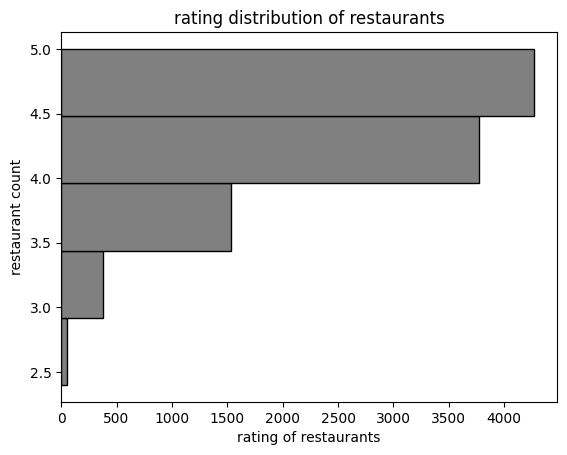

In [8]:
#for relation of rating
#we will see how many restraunts have rating of 1-5 using histogram
#to see the distribution of how rating is distributed in the range of restraunt

plt.title("rating distribution of restaurants")
plt.xlabel("rating of restaurants")
plt.ylabel("restaurant count")
plt.hist(training_data["rating"], color="grey", bins=5,edgecolor="black", orientation="horizontal")
plt.show()


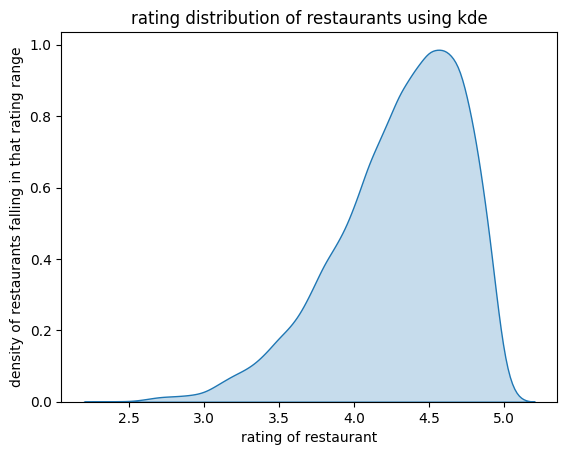

In [9]:
#plotting a kde of rating to see density distribution of restaurants vs rating 

plt.title("rating distribution of restaurants using kde")
plt.xlabel("rating of restaurant")
plt.ylabel("density of restaurants falling in that rating range")
sns.kdeplot(training_data["rating"],fill=True)
plt.show()


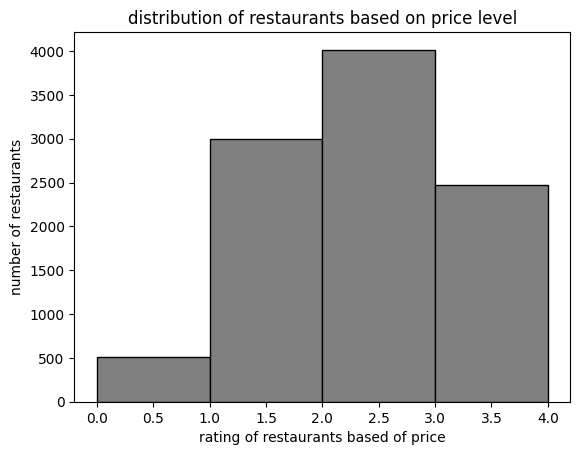

In [10]:
#we will visualise the restraunts based on price level in the range of 1-4 integers according to gopro api
#we will use histogram again to plot the range
plt.title("distribution of restaurants based on price level")
plt.xlabel("rating of restaurants based of price")
plt.ylabel("number of restaurants")
plt.hist(training_data["price_level"],color="grey",bins=4, edgecolor="black")
plt.show()
#most restaurants is having average price

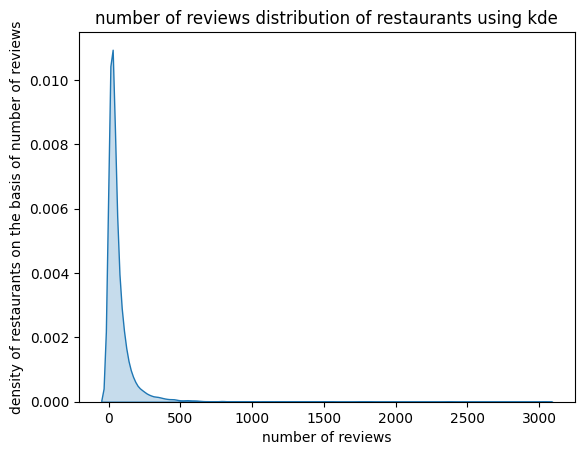

In [11]:
# we will plot a kde plot to map number of 
plt.title("number of reviews distribution of restaurants using kde")
plt.xlabel("number of reviews")
plt.ylabel("density of restaurants on the basis of number of reviews")
sns.kdeplot(training_data["total_reviews"],fill=True)
plt.show()


now we will do bivariate analysis of features to see how our data maps btwn two features of our data


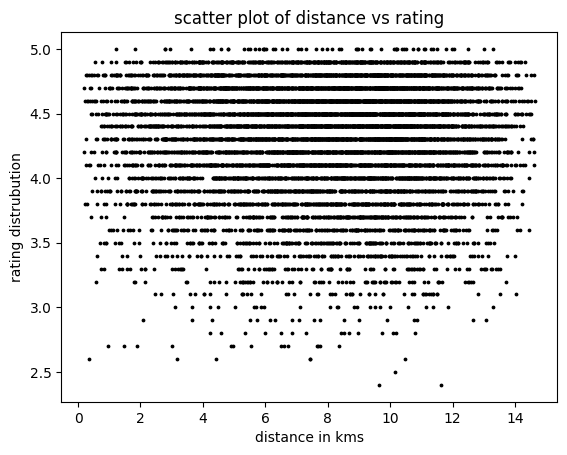

In [12]:
#we are plotting a scatter plot of distance vs rating to see if it maps any clusters which can tell any correlations 
# btwn the given features
x=training_data["distance_km"]
y=training_data["rating"]
plt.scatter(x,y,marker="o",color="black",s=3)
plt.title("scatter plot of distance vs rating")
plt.xlabel("distance in kms")
plt.ylabel("rating distrubution")
plt.show()
#most restaurants have btwn 1-2 kms and have rating of 3-4



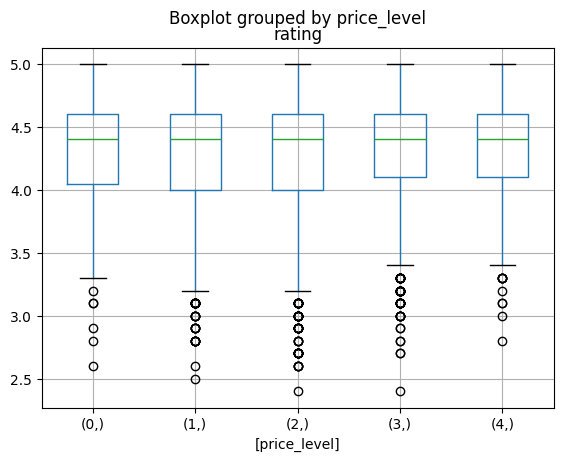

In [13]:
#now we will use boxplot to see the relationship btwn rating and price of resaurants


training_data.boxplot(column=["rating"], by=["price_level"])
plt.show()
#we can see there are few outliers in the dataset that means not every time restraunt thta is pricey is rated well

model training for ranking of top 10 restaurants in the place user searches
-----------------------------------------------------------------------------
work flow of the model-
1.user will input its current location
2.user will search the restaurant in the area he wants to go
3.we will get latitude and longitude of the start and end point  
4.using haversine formula we will calculate the distance in kilometers
5.now we will train the model on forkcast_data.csv (10000 fields)
6.model will evaluate and rank all the data in the search via api results and evaluate all the data on the basis of 
     following parameters priority wise
     1.distance
     2.number of reviews
     3.rating 
     4.price level
     
     
7.make a pickle file of the model using joblib for portability
    
    then recommend top 10 places with its info like address , distance , rating , price level , rank etc.

In [17]:
#model training begins..
model_dataframe=training_data.drop(["name"],axis=1)

model_dataframe["model_score"]=(-0.4*model_dataframe["distance_km"]+0.3*np.log1p(model_dataframe["total_reviews"])+0.1*model_dataframe["price_level"]+0.2*model_dataframe["rating"])
#model dataframe after score...
model_dataframe

random_forest=RandomForestRegressor()
x=model_dataframe[["rating","price_level","distance_km","total_reviews"]]
y=model_dataframe["model_score"]

X_test,X_train,y_test,y_train=train_test_split(x,y,test_size=0.2,random_state=42)

n_estimators=[20,60,80,100]
max_depth=[2,8,None]
max_features=[0.2,0.6,0.8]
max_samples=[0.5,0.75,1.0]
parameter_grid={
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'max_features':max_features,
    'max_samples':max_samples
}
grid_search=GridSearchCV(estimator=random_forest,param_grid=parameter_grid,cv=5,n_jobs=-1,verbose=2)
grid_search.fit(X_train,y_train)
print("best parameters are",grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
best parameters are {'max_depth': None, 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 80}


In [19]:
final_model=RandomForestRegressor(n_estimators=100,max_depth=None,max_features=0.8,max_samples=1.0)
final_model.fit(X_train,y_train)
print(final_model.score(X_test,y_test))
print(final_model.score(X_train,y_train))


0.995033890984676
0.9992502975106213


In [16]:
final_model_file=joblib.dump(final_model,"final_model_file.pkl")